In [1]:
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import numpy as np
from scipy.stats import median_abs_deviation

sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)
plt.rcParams['figure.figsize'] = (4,4)


controls2 = ['Dabrafenib', 'Belinostat']

In [2]:
sc_counts = ad.read_h5ad(f'input/sc_counts.h5ad')
sc_counts.var_names_make_unique()


In [3]:
CELL_TYPES = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells', 'B cells', 'Myeloid cells']
T_cell_types = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']
cell_type_map = {cell_type: 'T cells' if cell_type in T_cell_types else cell_type for cell_type in CELL_TYPES}

sc_counts.obs['cell_type'] = sc_counts.obs['cell_type'].map(cell_type_map)

In [4]:
sc_counts.obs['plate_name'] = sc_counts.obs['plate_name'].astype(str).apply(lambda name: name.split('-')[1]).astype('category')
# define specific id for cell type of each well 
sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_name'].astype('str') \
    + '_' + sc_counts.obs['well'].astype('str') \
    + '_' + sc_counts.obs['cell_type'].astype('str')
sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_well_cell_type'].astype('category')

# QC
Control for count depths, gene count, and mitochondrial ratio

In [5]:
sc.pp.calculate_qc_metrics(
    sc_counts, inplace=True, log1p=True
)
sc_counts

AnnData object with n_obs × n_vars = 301785 × 21265
    obs: 'dose_uM', 'timepoint_hr', 'raw_cell_id', 'hashtag_id', 'well', 'container_format', 'row', 'col', 'plate_name', 'cell_id', 'cell_type', 'split', 'donor_id', 'sm_name', 'plate_well_cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'HTO_clr', 'X_pca', 'X_umap', 'protein_counts'
    layers: 'counts'

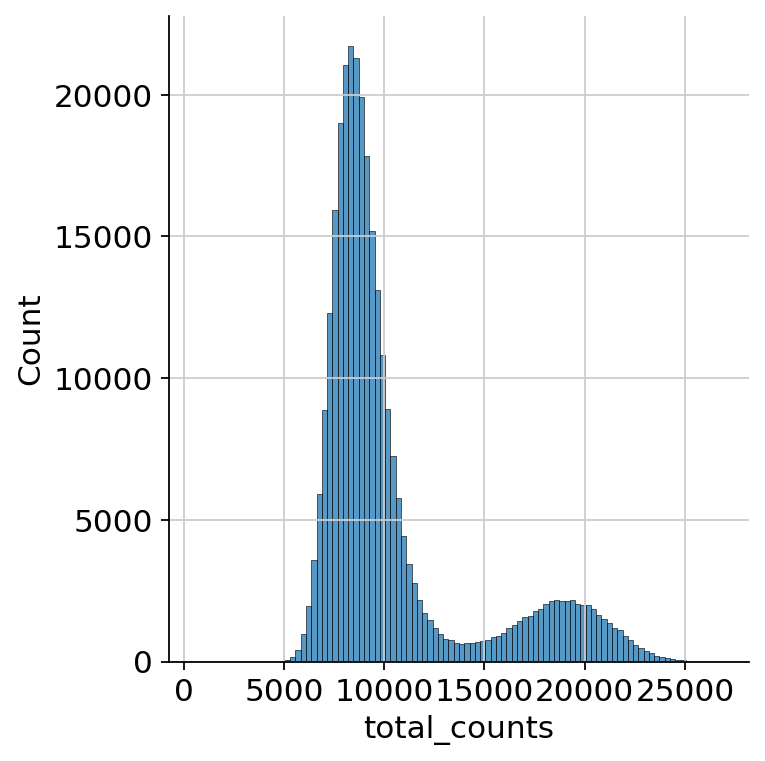

In [6]:
p1 = sns.displot(sc_counts.obs["total_counts"], bins=100, kde=False)

## Filtering cells

In [7]:
sc_counts.obs['positive_ctr'] = sc_counts.obs.sm_name.isin(controls2)

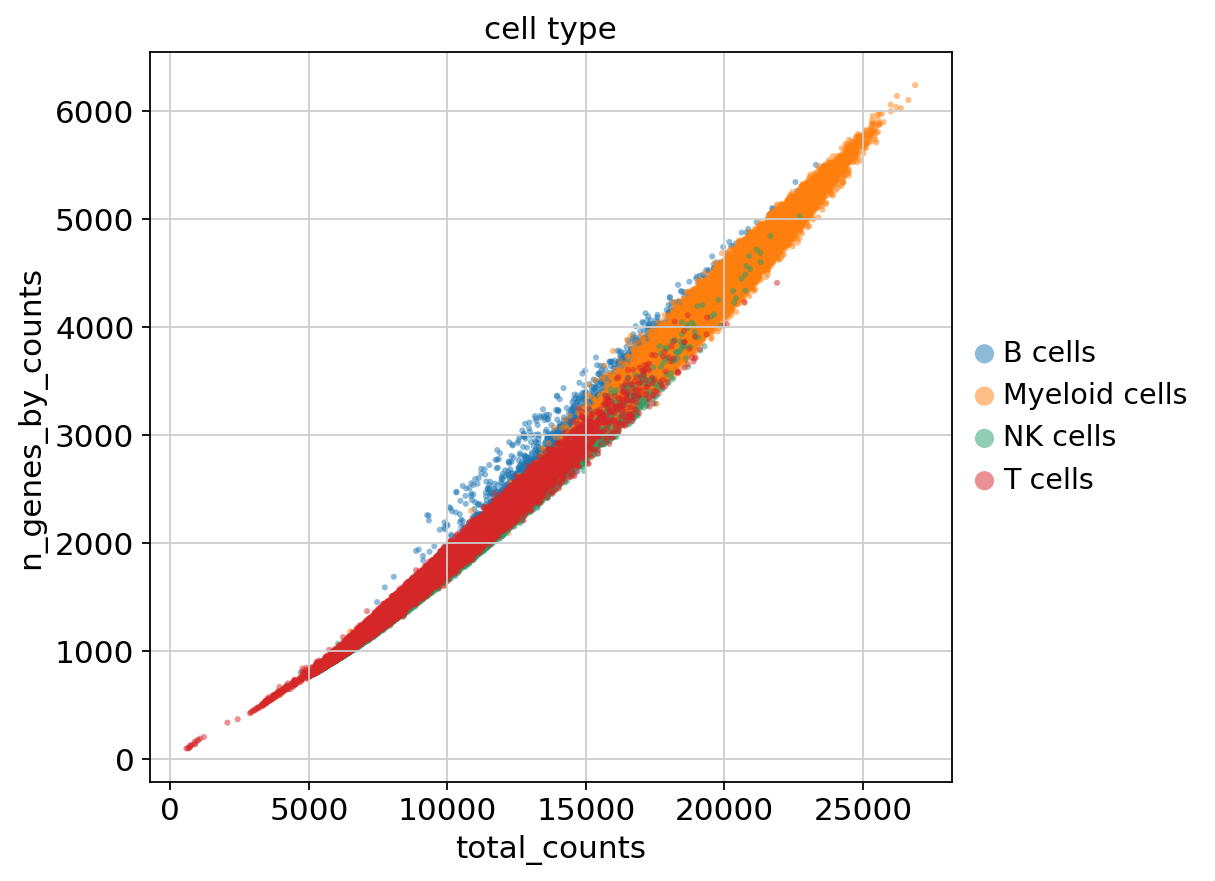

In [8]:
sc.set_figure_params(figsize=(6,6))
p3 = sc.pl.scatter(sc_counts, "total_counts", "n_genes_by_counts", color="cell_type", size=30, alpha=.5)

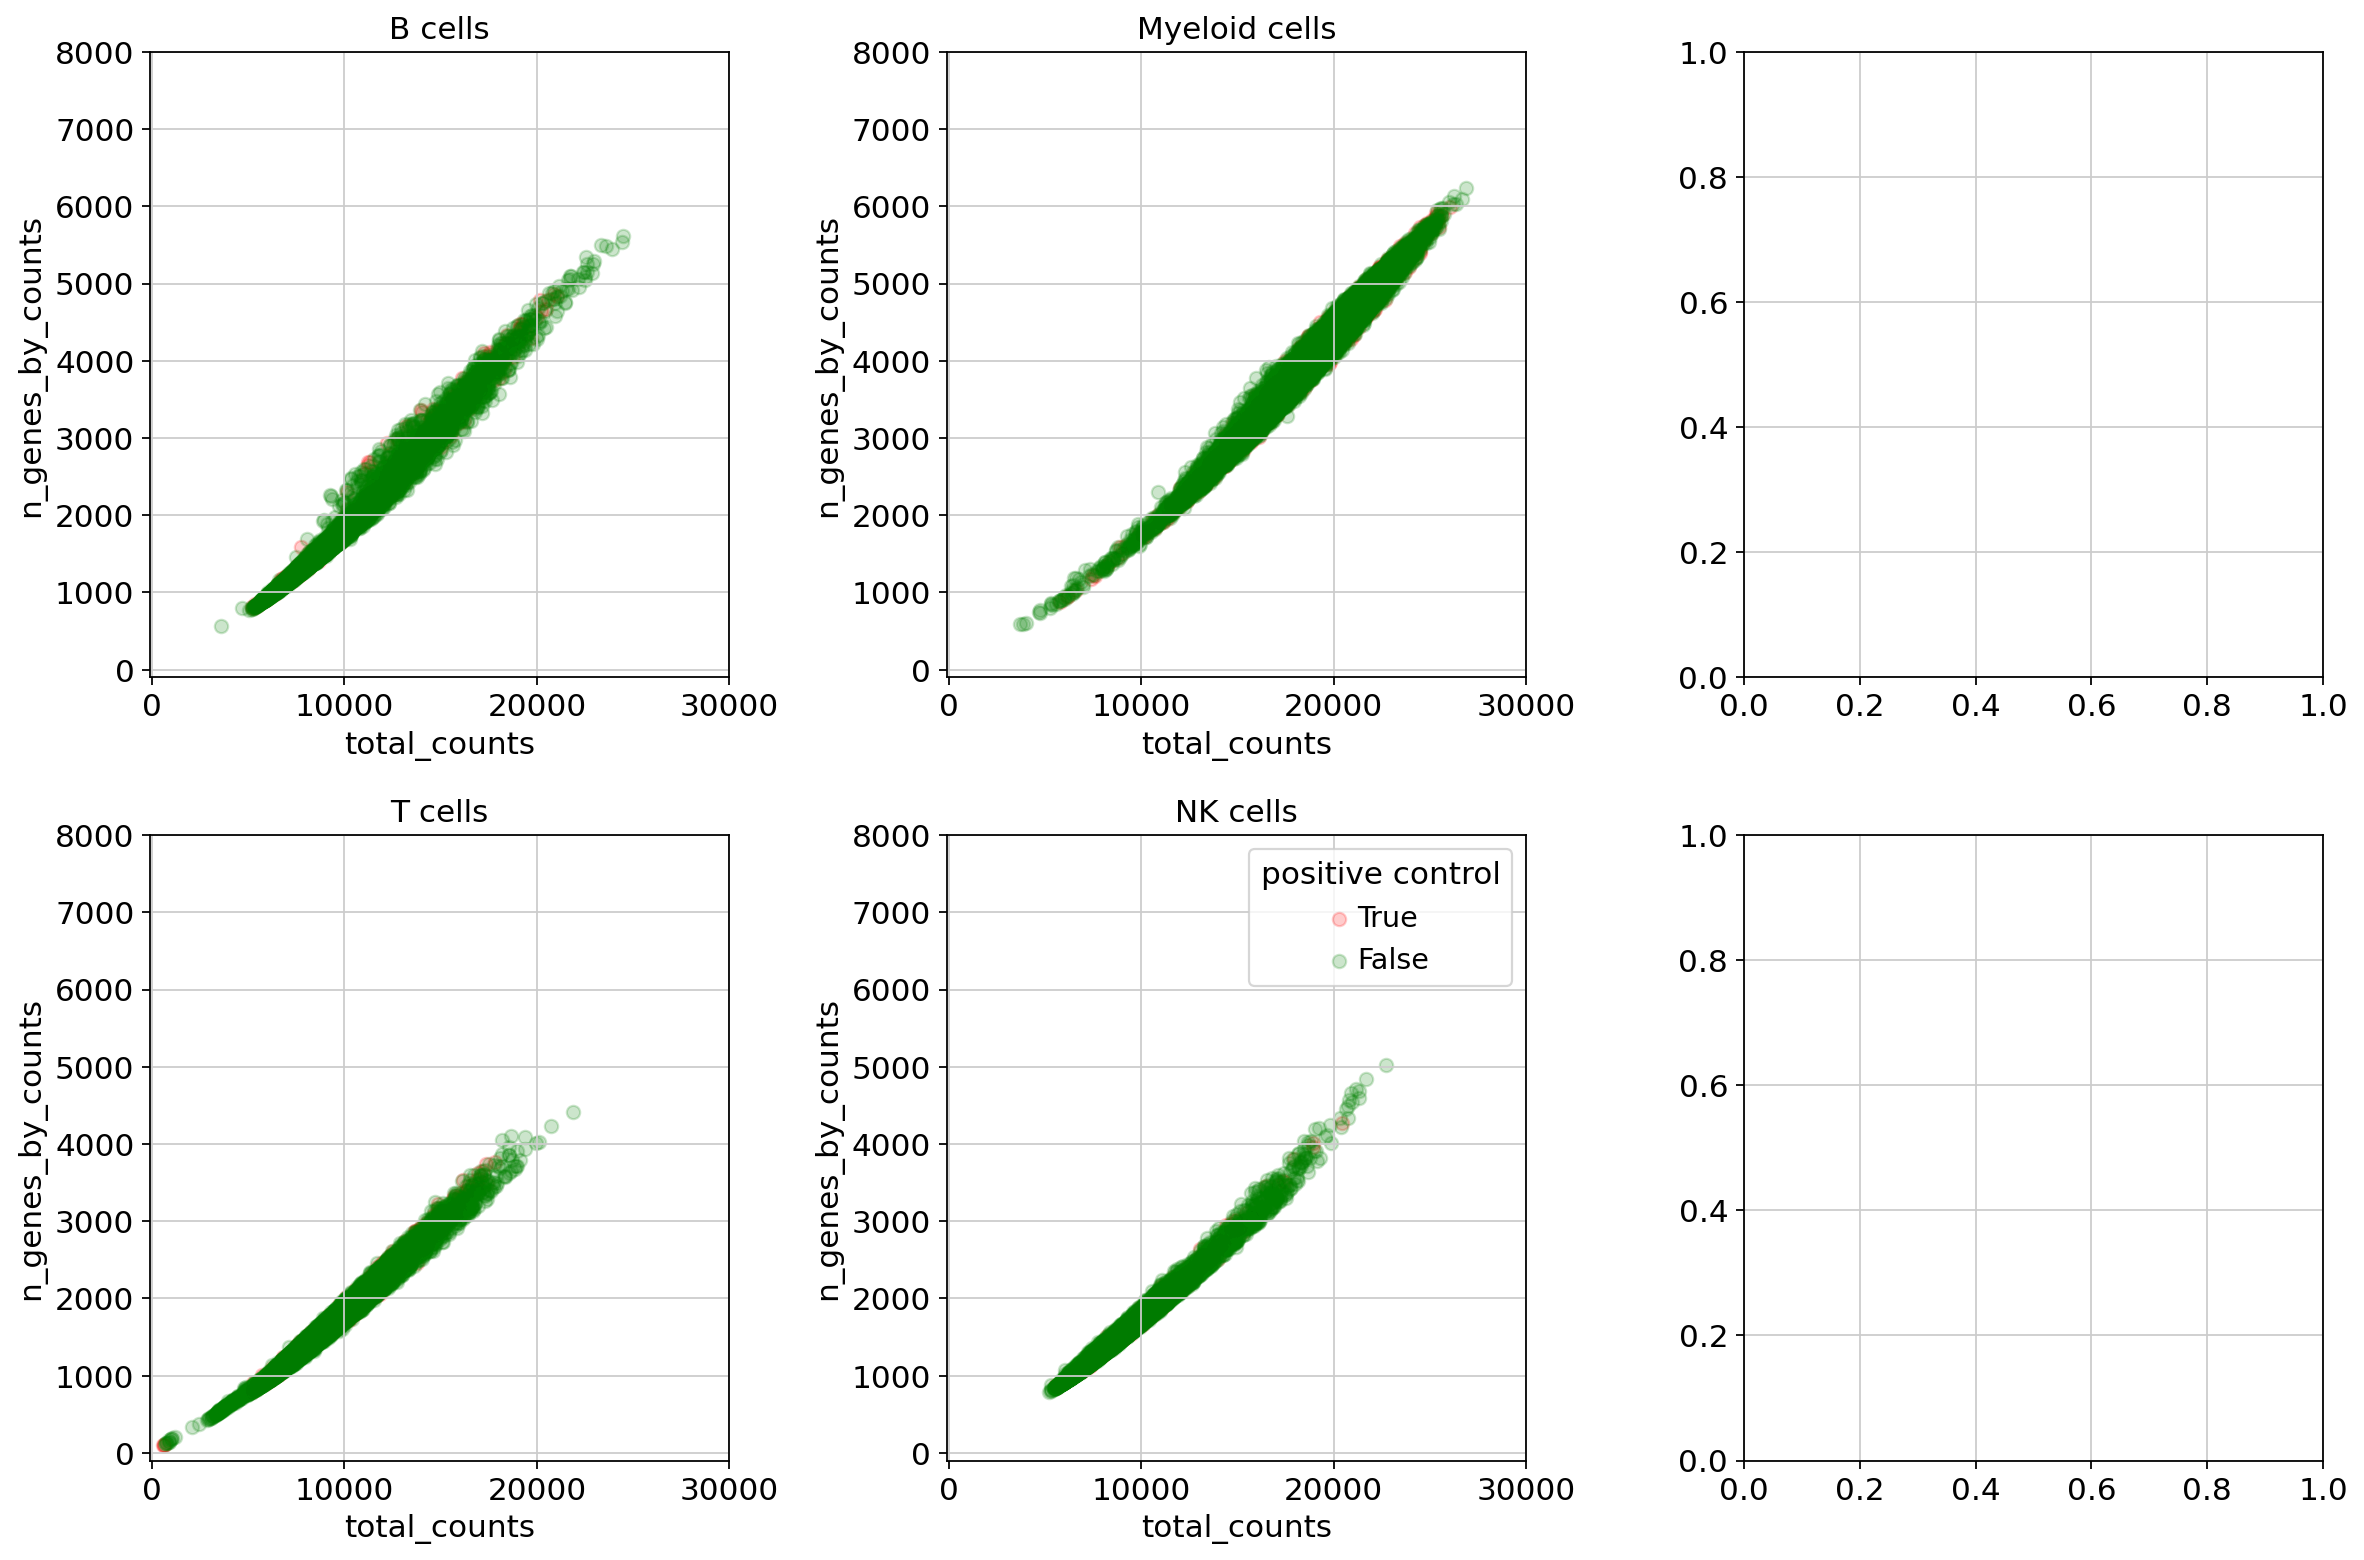

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

xlims = [-100, 30000]
ylims = [-100, 8000]
i_index = 0
xlabel = 'total_counts'
ylabel = 'n_genes_by_counts'
color = 'positive_ctr'

colors= ['red', 'green']
for cell_type in sc_counts.obs.cell_type.unique():
    i = i_index // 2
    j = i_index % 2
    ax = axes[j][i]
    
    adata_sub = sc_counts[sc_counts.obs.cell_type==cell_type, :]

    xdata = adata_sub.obs[xlabel]
    ydata = adata_sub.obs[ylabel]

    mask_data = adata_sub.obs[color]
    for cat_i, cat in enumerate(mask_data.unique()):
        mask = mask_data==cat
        ax.scatter(xdata[mask], ydata[mask], alpha=.2, label=cat, color=colors[cat_i])
    # p3 = sc.pl.scatter(adata_sub, "total_counts", "n_genes_by_counts", color="positive_ctr", size=30, alpha=.3, ax=ax)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_title(cell_type)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    i_index += 1
ax.legend(title='positive control')
plt.tight_layout()

### Filtering potential degragaded cells

In [10]:
# mitochondrial, ribosomal and hemoglobin genes
# mitochondrial genes
sc_counts.var["mt"] = sc_counts.var_names.str.startswith("MT-")
# ribosomal genes
sc_counts.var["ribo"] = sc_counts.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
sc_counts.var["hb"] = sc_counts.var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(
    sc_counts, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
sc_counts


AnnData object with n_obs × n_vars = 301785 × 21265
    obs: 'dose_uM', 'timepoint_hr', 'raw_cell_id', 'hashtag_id', 'well', 'container_format', 'row', 'col', 'plate_name', 'cell_id', 'cell_type', 'split', 'donor_id', 'sm_name', 'plate_well_cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'positive_ctr', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'
    uns: 'cell_type_colors'
    obsm: 'HTO_clr', 'X_pca', 'X_umap', 'protein_counts'
    layers: 'counts'

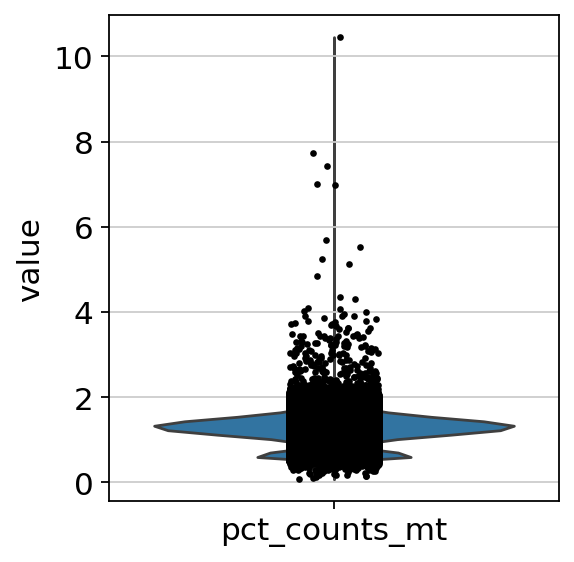

In [11]:
sc.set_figure_params(figsize=(4,4))
p2 = sc.pl.violin(sc_counts, "pct_counts_mt", size=3)

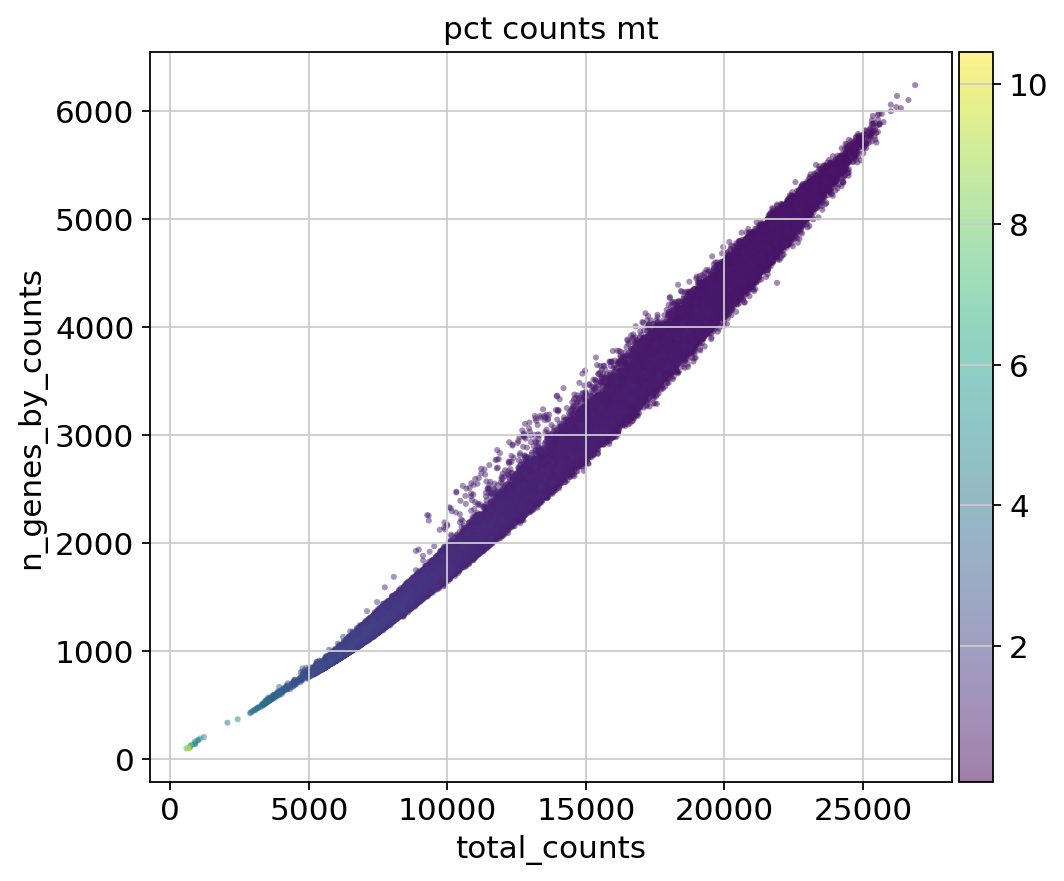

In [12]:
sc.set_figure_params(figsize=(6,6))
p3 = sc.pl.scatter(sc_counts, "total_counts", "n_genes_by_counts", color="pct_counts_mt", size=30, alpha=.5)

In [13]:
# mitichondrial related filter
filter_mask_mt = ((sc_counts.obs["pct_counts_mt"] > 3) & (sc_counts.obs["n_genes_by_counts"] < 1000) & (sc_counts.obs["total_counts"] < 5000))
filter_mask_mt.value_counts()

False    301693
True         92
Name: count, dtype: int64

### Cell with insufficient genes and counts

In [14]:
# low expression filter
filter_low_expression = ((sc_counts.obs["n_genes_by_counts"] < 1000) & (sc_counts.obs["total_counts"] < 5000))
filter_low_expression.value_counts()

False    301593
True        192
Name: count, dtype: int64

In [15]:
sc_counts = sc_counts[~filter_low_expression | ~filter_mask_mt, :]
sc_counts

View of AnnData object with n_obs × n_vars = 301693 × 21265
    obs: 'dose_uM', 'timepoint_hr', 'raw_cell_id', 'hashtag_id', 'well', 'container_format', 'row', 'col', 'plate_name', 'cell_id', 'cell_type', 'split', 'donor_id', 'sm_name', 'plate_well_cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'positive_ctr', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'
    uns: 'cell_type_colors'
    obsm: 'HTO_clr', 'X_pca', 'X_umap', 'protein_counts'
    layers: 'counts'

## Filtering low quality genes
keep those genes that are expressed in at least 1 percent of cells within a plate

In [16]:
p_threshold = .01 # fraction of cells that a gene should be present 
genes_tokeep_mask = np.ones(sc_counts.shape[1], dtype=bool)
for plate in sc_counts.obs['plate_name'].unique():
    mask = sc_counts.obs['plate_name'] == plate
    sc_counts_subset = sc_counts[mask,:]
    sum_samples = np.ravel(sc_counts_subset.X.sum(axis=0))
    
    cell_n = sc_counts[mask,:].shape[0]
    tt = p_threshold*cell_n

    print(genes_tokeep_mask.sum())
    genes_tokeep_mask = genes_tokeep_mask*(sum_samples>tt)

    

21265
16750
16571
16229
16088
15872


In [17]:
sc_counts = sc_counts[:, genes_tokeep_mask]
sc_counts

View of AnnData object with n_obs × n_vars = 301693 × 15845
    obs: 'dose_uM', 'timepoint_hr', 'raw_cell_id', 'hashtag_id', 'well', 'container_format', 'row', 'col', 'plate_name', 'cell_id', 'cell_type', 'split', 'donor_id', 'sm_name', 'plate_well_cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'positive_ctr', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'
    uns: 'cell_type_colors'
    obsm: 'HTO_clr', 'X_pca', 'X_umap', 'protein_counts'
    layers: 'counts'

# Pseudobulking counts 

In [18]:
import anndata
import pandas as pd
import numpy as np
import sklearn
import scipy
import warnings

warnings.filterwarnings('ignore', category=FutureWarning, message="The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated")
warnings.filterwarnings('ignore', category=UserWarning, message="No data for colormapping provided via 'c'")

import anndata as ad
import scanpy as sc

import matplotlib.pyplot as plt

import os, binascii
from scipy import sparse



In [19]:

def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    """
    Adapted from this forum post: 
    https://discourse.scverse.org/t/group-sum-rows-based-on-jobs-feature/371/4
    """
    
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    # sum `.X` entries for each unique value in `col`
    cat = adata.obs[col].values

    indicator = sparse.coo_matrix(
        (
            np.broadcast_to(True, adata.n_obs),
            (cat.codes, np.arange(adata.n_obs))
        ),
        shape=(len(cat.categories), adata.n_obs),
    )
  
    sum_adata = ad.AnnData(
        indicator @ adata.X,
        var=adata.var,
        obs=pd.DataFrame(index=cat.categories),
    )
    
    # copy over `.obs` values that have a one-to-one-mapping with `.obs[col]`
    obs_cols = adata.obs.columns
    obs_cols = list(set(adata.obs.columns) - set([col]))
    
    one_to_one_mapped_obs_cols = []
    nunique_in_col = adata.obs[col].nunique()
    for other_col in obs_cols:
        if len(adata.obs[[col, other_col]].drop_duplicates()) == nunique_in_col:
            one_to_one_mapped_obs_cols.append(other_col)

    joining_df = adata.obs[[col] + one_to_one_mapped_obs_cols].drop_duplicates().set_index(col)
    assert (sum_adata.obs.index == sum_adata.obs.join(joining_df).index).all()
    sum_adata.obs = sum_adata.obs.join(joining_df)
    sum_adata.obs.index.name = col
    sum_adata.obs = sum_adata.obs.reset_index()
    sum_adata.obs.index = sum_adata.obs.index.astype('str')

    return sum_adata

In [20]:
# actuall bulking
bulk_adata = sum_by(sc_counts, 'plate_well_cell_type')
bulk_adata.obs['cell_count'] = sc_counts.obs.groupby('plate_well_cell_type').size().values
bulk_adata.X = np.array(bulk_adata.X.todense())

print('ratio of missingness' , (bulk_adata.X==0).sum()/bulk_adata.X.size)
bulk_adata.var = bulk_adata.var.reset_index()

/tmp/ipykernel_32050/3217760403.py:7: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  assert pd.api.types.is_categorical_dtype(adata.obs[col])
/tmp/ipykernel_32050/4145480475.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bulk_adata.obs['cell_count'] = sc_counts.obs.groupby('plate_well_cell_type').size().values


ratio of missingness 0.22070971074222684


In [21]:
bulk_adata.var.set_index('index', inplace=True)
bulk_adata.var.head()

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,mt,ribo,hb
index,,,,,,,,,
A1BG,4001,0.065683,0.063616,98.674222,19822.047544,9.894601,False,False,False
A1BG-AS1,9896,0.157182,0.145987,96.720844,47435.027412,10.767137,False,False,False
A2M,23246,0.377381,0.320184,92.297165,113887.837318,11.642978,False,False,False
A2M-AS1,23010,0.413688,0.346202,92.375367,124844.773609,11.734834,False,False,False
A2MP1,1613,0.028949,0.028538,99.465514,8736.511360,9.075381,False,False,False


In [22]:
bulk_adata.obs.groupby(['cell_type', 'sm_name']).size()

/tmp/ipykernel_32050/2166608923.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bulk_adata.obs.groupby(['cell_type', 'sm_name']).size()


cell_type  sm_name                                                             
B cells    5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine    3
           ABT737                                                                  3
           ABT-199 (GDC-0199)                                                      3
           AMD-070 (hydrochloride)                                                 3
           AT13387                                                                 3
                                                                                  ..
T cells    Vandetanib                                                              3
           Vanoxerine                                                              3
           Vardenafil                                                              3
           Vorinostat                                                              3
           YK 4-279                                                   

In [23]:
bulk_adata.write('output/bulk_adata_complete_tcells.h5ad')

In [24]:
aa

NameError: name 'aa' is not defined

# Other

In [ ]:
df = pd.DataFrame(sc_counts.X.todense(), columns=sc_counts.var.index)

In [ ]:
df['well_id'] = sc_counts.obs['plate_name'].astype(str) + '__' + sc_counts.obs['well'].astype(str)
sc_counts_well = df.groupby('well_id').size()

In [ ]:
aa = plt.hist(sc_counts_well, bins=100)

In [ ]:
df.set_index('well_id', inplace=True)

In [ ]:
samples_pergene_well = df.groupby('well_id').apply(lambda df: (df!= 0).sum(axis=0))

In [ ]:
samples_pergene_well = min_sample_pergene_well

In [ ]:
samples_pergene_well